<a href="https://colab.research.google.com/github/whwhwp/document-qa/blob/main/cnn_fastfood_classification_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up Environment & Prepare the Dataset

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import zipfile
import seaborn as sns
import pandas as pd
import tensorflow as tf
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check for GPU / TPU

try:
    if os.environ['COLAB_TPU_ADDR']:
        cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
        tf.config.experimental_connect_to_cluster(cluster_resolver)
        tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
        strategy = tf.distribute.TPUStrategy(cluster_resolver)
        print('Using TPU')
    elif tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy()
        print('Using GPU')
    else:
        raise ValueError('Running on CPU is not recommended.')
except KeyError:
    if tf.config.list_physical_devices('GPU'):
        strategy = tf.distribute.MirroredStrategy()
        print('Using GPU')
    else:
        raise ValueError('Running on CPU is not recommended.')

Using GPU


In [ ]:
def extract_zip(filename, input_path, output_path):
    print("Start extracting zip file.")
    with zipfile.ZipFile(input_path, 'r') as zip_file:
        zip_file.extractall(output_path)
    print("Finished.")

In [ ]:
source_path = '/content/drive/MyDrive/fastfood'
target_path = './data'
filename = "Train"
extract_zip(filename, os.path.join(source_path, filename+".zip"), target_path)
print("DONE")

Start extracting zip file.
Finished.
DONE


In [ ]:
data_path = os.path.join(target_path, filename)

classes = sorted(os.listdir(data_path))
classes = {i:item for i, item in enumerate(classes)}
classes_rev = {value:key for key,value in classes.items()}
print(classes)

{0: 'Baked Potato', 1: 'Burger', 2: 'Crispy Chicken', 3: 'Donut', 4: 'Fries', 5: 'Hot Dog', 6: 'Pizza', 7: 'Sandwich', 8: 'Taco', 9: 'Taquito'}


# Preprocess the dataset

In [ ]:
# Load train dataset

data, labels = [], []

for key in classes_rev.keys() :
    img_path = os.path.join(data_path, key)
    images = os.listdir(img_path)
    for image in images:
        img = Image.open(os.path.join(img_path, image)).convert("RGB").resize((64,64))
        data.append(np.array(img).astype('float32')/255)
        labels.append(classes_rev[key])

data = np.array(data)
labels = np.array(labels)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
print(data.shape)
print(labels.shape)

(10000, 64, 64, 3)
(10000,)


In [ ]:
# Load test dataset

filename = "Test"
extract_zip(filename, os.path.join(source_path, filename+".zip"), target_path)
print("DONE")

test_data_path = "/content/data/Test"
test_data = []

sorted_name = sorted([int(name.split('.')[0]) for name in os.listdir(test_data_path)])
sorted_path = [str(name)+".jpeg" for name in sorted_name]

for image in sorted_path:
    img = Image.open(os.path.join(test_data_path, image)).convert("RGB").resize((64,64))
    test_data.append(np.array(img).astype('float32')/255)

test_data = np.array(test_data)

print(test_data.shape)

Start extracting zip file.
Finished.
DONE
(10000, 64, 64, 3)


Num of Class:  10
Num of samples per Class [ 500  500  500  500  500 1500 1500 1500 1500 1500]


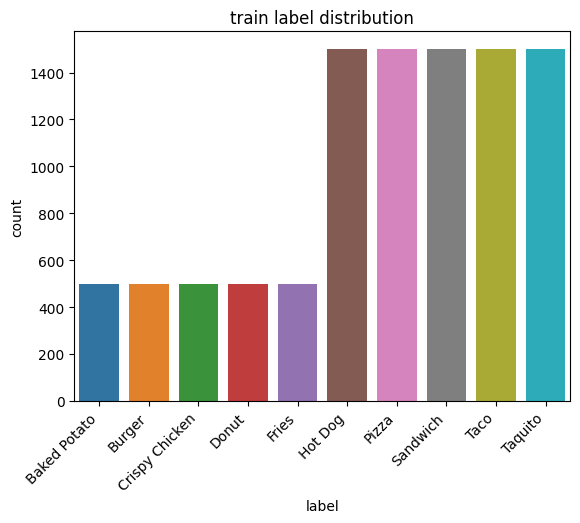

In [ ]:
classes_, counts = np.unique(labels, return_counts=True)
num_classes = len(classes_)
print("Num of Class: ", num_classes)
print("Num of samples per Class", counts)

train_label_str = [classes[label_int] for label_int in labels.tolist()]
df_train_label = pd.DataFrame(train_label_str, columns=['label'])
ax = sns.countplot(x='label', data=df_train_label, order=list(classes_rev.keys()))
ax.set_title('train label distribution')
plt.xticks(rotation=45, ha="right")
plt.show()

In [ ]:
#이미지 제네레이터 예시
from tensorflow.keras.preprocessing.image import ImageDataGenerator

with strategy.scope():
  generator = ImageDataGenerator(
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip = True,
      zoom_range = 0.2,
      shear_range = 0.1,
      )

  generator.fit(X_train)

In [ ]:
training_image_aug = generator.flow(X_train, np.zeros(len(X_train)), batch_size=len(X_train), shuffle=False).next()[0]
training_image_aug2 = generator.flow(X_train, np.zeros(len(X_train)), batch_size=len(X_train), shuffle=False).next()[0]

X_train = np.concatenate((X_train,
                          training_image_aug,
                          training_image_aug2))

Y_train = np.concatenate((Y_train,
                          Y_train,
                          Y_train))


In [ ]:
#Class weight 예시
class_weight = compute_class_weight(
    class_weight="balanced" ,
    classes=np.unique(labels),
    y=labels)
class_weight = {i: class_weight[i] for i in range(num_classes)}

In [ ]:
history = model.fit(X_train, Y_train, epochs=epochs, validation_data = (X_valid, Y_valid), class_weight=class_weight)